In [254]:
%pylab inline

import numpy as np
import pandas as pd
import pydot

from io import StringIO
from sklearn.tree import export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import Image, display

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stack', 'clf', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Titanic Survival Dataset

* [데이터 다운로드 및 설명 링크](https://www.kaggle.com/c/titanic/data)

In [554]:
def get_raw_dataset():
    # Preprocessing Raw Dataset
    train_df = pd.read_csv('train.csv')
#     train_df.dropna(inplace=True)
    
    columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    y_train = np.array(train_df['Survived'])
    x_train = train_df[columns]
    
    # Convert Datatype
    # x_train['Sex'].astype('category', inplace=True)
    # x_train['Embarked'].astype('category', inplace=True)
    
    return x_train, y_train
    
x_train, y_train = get_raw_dataset()

# Missing Value
print('Missing Values')
display(x_train.isna().sum())

print('shape:', x_train.shape)
x_train.head()

Missing Values


Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

shape: (891, 6)


,Sex,Age,SibSp,Parch,Fare,Embarked
0,male,22.0,1,0,7.2500,S
1,female,38.0,1,0,71.2833,C
2,female,26.0,0,0,7.9250,S
3,female,35.0,1,0,53.1000,S
4,male,35.0,0,0,8.0500,S


# Model

## Decision Tree

### Preprocessing & Training
 
 - Sex
   - Female: 0
   - Male: 1
 - Age 
   - Missing value: 평균값 사용 
 - Embarked 
   - Missing value: mode 사용 (가장 빈도수가 많은 값)

In [718]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

x_train, y_train = get_raw_dataset()


# Missing Values
x_train['Age'].loc[x_train['Age'].isna()] = x_train['Age'].mean()
x_train['Embarked'].loc[x_train['Embarked'] == None] = x_train['Embarked'].mode()

# Encoding
label_encoder = LabelEncoder()
x_train = pd.get_dummies(x_train, columns=['Embarked'])
x_train['Sex'] = label_encoder.fit_transform(x_train['Sex'])


print('[Training Data]')
display(x_train.head())

# Train
clf = DecisionTreeClassifier(max_depth=12)
clf = clf.fit(x_train, y_train)

# Validation on Train data
y_pred = clf.predict(x_train)
print('[Classification Report]')
print(classification_report(y_train, y_pred))

[Training Data]


,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0,0,1
1,0,38.0,1,0,71.2833,1,0,0
2,0,26.0,0,0,7.9250,0,0,1
3,0,35.0,1,0,53.1000,0,0,1
4,1,35.0,0,0,8.0500,0,0,1


[Classification Report]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       549
           1       0.95      0.86      0.90       342

    accuracy                           0.93       891
   macro avg       0.94      0.92      0.92       891
weighted avg       0.93      0.93      0.93       891



### Visualization

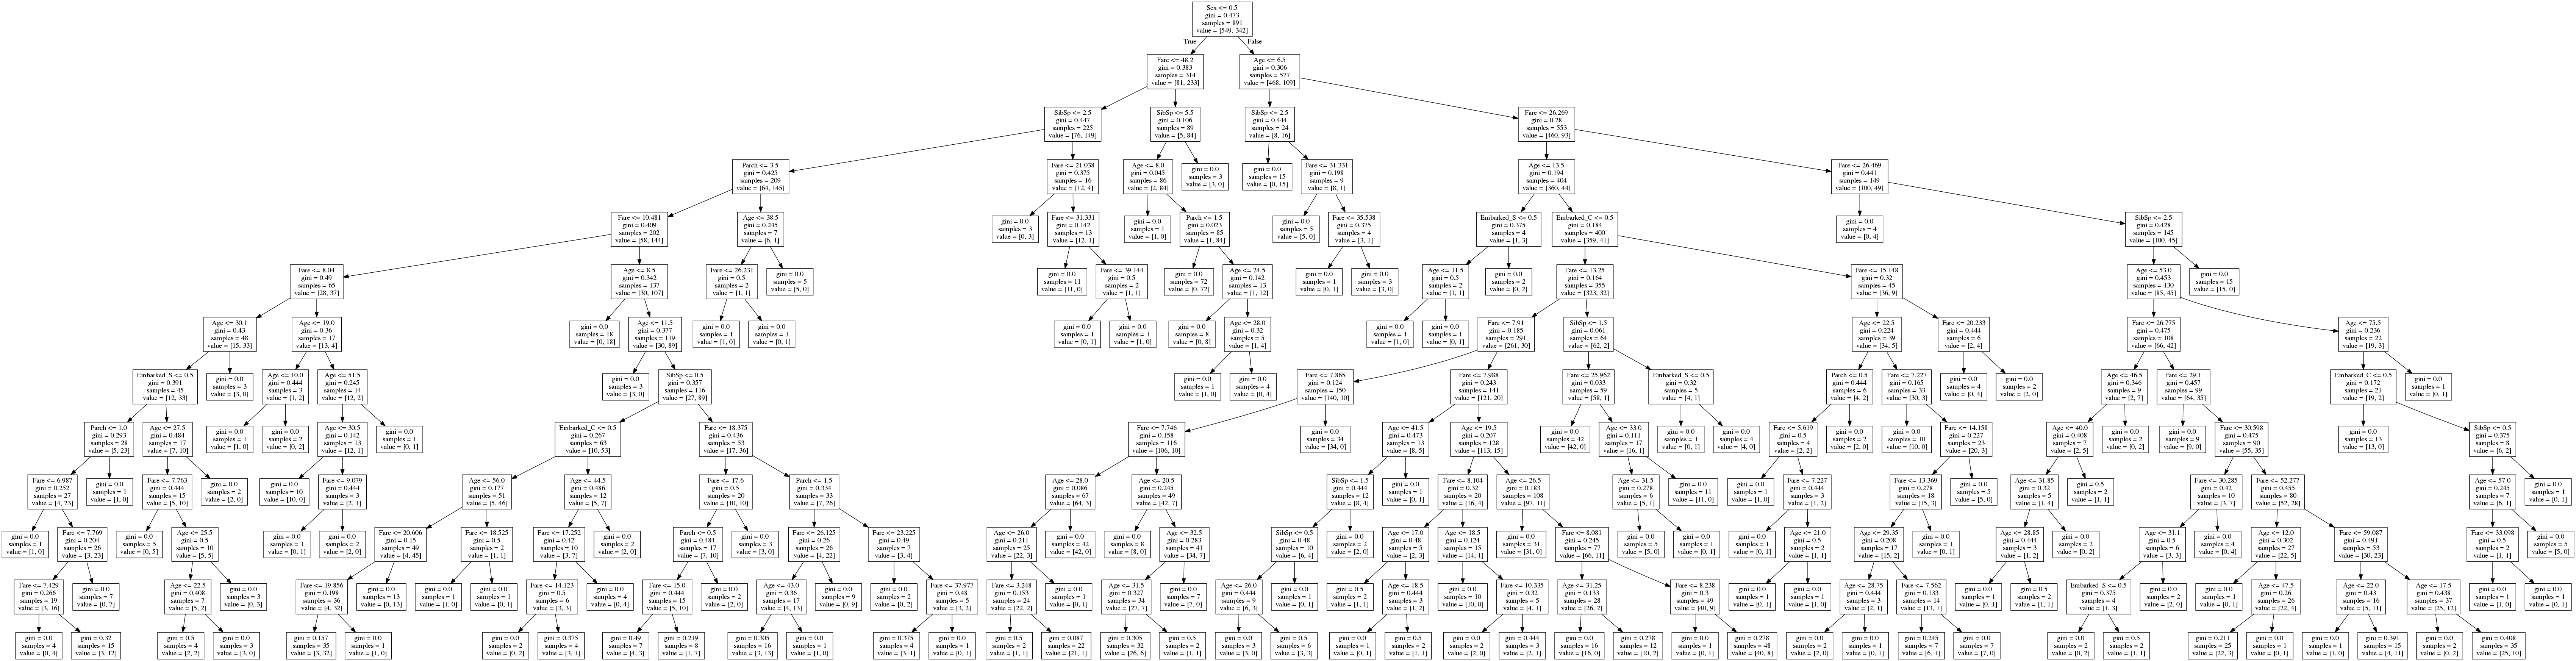

In [719]:
f = StringIO()
export_graphviz(clf, out_file=f,
                feature_names=x_train.columns.tolist())
graph = pydot.graph_from_dot_data(f.getvalue())[0]
graph.write_png('titanic_decision_tree.png')
Image(filename='titanic_decision_tree.png')

### Cause Analysis

In [720]:
from sklearn.tree._tree import TREE_UNDEFINED
columns = x_train.columns

features = np.array(columns[clf.tree_.feature])
features[clf.tree_.feature == TREE_UNDEFINED] = None
features

array(['Sex', 'Fare', 'SibSp', 'Parch', 'Fare', 'Fare', 'Age',
       'Embarked_S', 'Parch', 'Fare', None, 'Fare', 'Fare', None, None,
       None, None, 'Age', 'Fare', None, 'Age', 'Age', None, None, None,
       None, None, 'Age', 'Age', None, None, 'Age', 'Age', None, 'Fare',
       None, None, None, 'Age', None, 'Age', None, 'SibSp', 'Embarked_C',
       'Age', 'Fare', 'Fare', None, None, None, 'Fare', None, None, 'Age',
       'Fare', 'Fare', None, None, None, None, 'Fare', 'Fare', 'Parch',
       'Fare', None, None, None, None, 'Parch', 'Fare', 'Age', None, None,
       None, 'Fare', None, 'Fare', None, None, 'Age', 'Fare', None, None,
       None, 'Fare', None, 'Fare', None, 'Fare', None, None, 'SibSp',
       'Age', None, 'Parch', None, 'Age', None, 'Age', None, None, None,
       'Age', 'SibSp', None, 'Fare', None, 'Fare', None, None, 'Fare',
       'Age', 'Embarked_S', 'Age', None, None, None, 'Embarked_C', 'Fare',
       'Fare', 'Fare', 'Fare', 'Age', 'Age', 'Fare', None, No

In [773]:
from sklearn.tree._tree import TREE_UNDEFINED
from pprint import pprint

def get_decision_path(data, columns):
    features = np.array(columns[clf.tree_.feature])
    features[clf.tree_.feature == TREE_UNDEFINED] = None
    
    dp = clf.decision_path(data)
    n = dp.shape[0]
    
    response = []
    for i in range(n):
        node_indices = dp.indices[dp.indptr[i]: dp.indptr[i + 1]]
        
        node_features = features[node_indices][:-1]
        node_thresholds = clf.tree_.threshold[node_indices][:-1].round(2)
        causes = list(zip(node_features, node_thresholds))
        causes = [[f, t, data[f].values[0] <= t] for f, t in causes]
        response.append(causes)
    return response
        
    
columns = np.array(x_train.columns)
x_sample = x_train.sample(1)
y_sample = y_train[x_sample.index]
decision_pathes = get_decision_path(x_sample, columns)

display(x_sample)
print('살았음' if y_sample[0] == 1 else '죽었음')
pprint(decision_pathes[0])

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
83,1,28.0,0,0,47.1,0,0,1


죽었음
[['Sex', 0.5, False],
 ['Age', 6.5, False],
 ['Fare', 26.27, False],
 ['Fare', 26.47, False],
 ['SibSp', 2.5, True],
 ['Age', 53.0, True],
 ['Fare', 26.77, False],
 ['Fare', 29.1, False],
 ['Fare', 30.6, False],
 ['Fare', 52.28, True],
 ['Age', 12.0, False],
 ['Age', 47.5, True]]


In [830]:
def summary_decision_path(decision_pathes, x_data, columns):
    for dp in decision_pathes:
        h = {}

        for i, (feature, threshold, is_lower) in enumerate(dp):
            x_value = x_data[feature].values[0]

            h.setdefault((feature, is_lower), [i, threshold, x_value])
            h_key = (feature, is_lower)
            h_value = [h[h_key][0], threshold, x_value]

            if is_lower:
                h_value = min(h[h_key], h_value, key=lambda x: x[1])
            else:
                h_value = max(h[h_key], h_value, key=lambda x: x[1])

            h[h_key] = h_value
        
        uniq_features = {k[0] for k in h.keys()}
        for feature in uniq_features:
            value_low = h.get((feature, True))
            value_high = h.get((feature, False))
            print(value_low, feature)
            
            
        
#         h = [[k[0], ] for k, v in h.items()]


summary_decision_path(decision_pathes, x_sample, columns)

[5, 47.5, 28.0] Age
[9, 52.28, 47.1] Fare
None Sex
[4, 2.5, 0] SibSp
